In [1]:
# Basic Module
import numpy as np
import pandas as pd

# Graphic Module
import matplotlib.pyplot as plt
import seaborn as sns

# EDA
from scipy.stats import chi2, chi2_contingency, pointbiserialr
from scipy.stats.contingency import association

# ML/DL Algoritm
from sklearn.linear_model import LogisticRegression  # Logistic
from sklearn.linear_model import SGDClassifier  # SGD
from sklearn import svm  # SVM
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # Random Forest
from sklearn.ensemble import GradientBoostingClassifier  # GBT
from sklearn.ensemble import AdaBoostClassifier  # Adaboost
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  # Decision Tree
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.naive_bayes import GaussianNB  # Naive Bayes

# lightgbm, xgboost도 해보자


# Encoding
from sklearn.preprocessing import OneHotEncoder

# Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Verification
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve, validation_curve, LearningCurveDisplay

# warning message ignore
import warnings
warnings.filterwarnings(action='ignore')

## Data Loading

In [2]:
telco_data = pd.read_csv("./result_data/Modeling_Churn.csv", header=0, encoding='utf-8')

In [3]:
telco_data.head()

,Age,Age Group,Number of Dependents,Membership,Satisfaction Score,Tech services,Streaming services,Combined Product,Contract,Tenure in Months,Monthly Charge,Total Revenue,Churn Value
0,78,70,0,None,3,1,1,2,Month-to-Month,1,39.65,59.65,1
1,74,70,1,Offer E,3,1,0,4,Month-to-Month,8,80.65,1024.10,1
2,71,70,3,Offer D,2,0,2,4,Month-to-Month,18,95.45,1910.88,1
3,78,70,1,Offer C,2,2,2,4,Month-to-Month,25,98.50,2995.07,1
4,80,80,1,Offer C,2,0,0,4,Month-to-Month,37,76.50,3102.36,1


## Pre-Analysis, EDA

In [4]:
telco_data_cp = telco_data.copy()
telco_data_cp.drop(columns=['Age Group'], inplace=True)

### Object-Object, Chi-Square

In [5]:
categorical_column_list = []
for i in range(len(telco_data_cp.columns)):
    if telco_data_cp[telco_data_cp.columns[i]].dtype == 'object':
        if len(telco_data_cp[telco_data_cp.columns[i]].unique()) <= 100 and len(telco_data_cp[telco_data_cp.columns[i]].unique()) != 1:
            categorical_column_list.append(telco_data_cp.columns[i])

In [6]:
chi_result = pd.DataFrame(columns=['Column', 'Chi-SQ', 'P-value(0.05)', 'H0/H1', 'Corr'])  # 컬럼명, 카이제곱값, p값, 독립/상관 여부, 상관계수
# 카이제곱값이 클수록 예측결과와 실제 결과가 다름을 의미하며, 유의미한 관련성을 가짐
# alpha는 0.05로 작성

for col_name in categorical_column_list:
    ct_result = pd.crosstab(telco_data_cp[str(col_name)], telco_data_cp['Churn Value'])

    chi, p, dof, expected = chi2_contingency(ct_result)

    # 유의수준 0.05, 5%이내
    if p < 0.05:
        R_h0 = '상관'
    else:
        R_h0 = '독립'
    
    if len(ct_result) > 2:  # crosstab 결과로, 어느 축이든 변수가 2개 이상이면 Cramer-V 로 상관 계수를 구함
        corr_value = association(ct_result, method='cramer')
    else:  # x/y 축 모두 변수가 2개이면, phi corr로 상관 계수를 구함
        corr_value = telco_data_cp[(str(col_name)+'_label')].corr(telco_data_cp['Churn Value'])
    
    chi_result.loc[len(chi_result)] = [col_name, chi, p, R_h0, corr_value]


In [7]:
chi_result.sort_values('Corr', ascending=False).reset_index(drop=True)

,Column,Chi-SQ,P-value(0.05),H0/H1,Corr
0,Contract,1445.293243,0.000000e+00,상관,0.453001
1,Membership,481.725489,7.020357e-102,상관,0.261530


### Object-Numeric, Point Biserial

In [8]:
Numeric_column_list = []
for i in range(len(telco_data_cp.columns)):
    if telco_data_cp[telco_data_cp.columns[i]].dtype == 'float64' or telco_data_cp[telco_data_cp.columns[i]].dtype == 'int64':
            Numeric_column_list.append(telco_data_cp.columns[i])

In [9]:
ttest_result = pd.DataFrame(columns=['Column', 'PB-correlation', 'P-value(0.05)', 'H0/H1'])  # 컬럼명, 상관계수, p값, 독립/상관

for col_name in Numeric_column_list:
    ttest, p = pointbiserialr(telco_data_cp['Churn Value'], telco_data_cp[col_name])

    if p < 0.05:
        R_h0 = '상관'
    else:
        R_h0 = '독립'

    ttest_result.loc[len(ttest_result)] = [col_name, ttest, p, R_h0]

In [10]:
ttest_result.sort_values('PB-correlation', ascending=False).reset_index(drop=True)

,Column,PB-correlation,P-value(0.05),H0/H1
0,Churn Value,1.000000,0.000000e+00,상관
1,Combined Product,0.268476,1.478729e-116,상관
2,Monthly Charge,0.193356,2.706646e-60,상관
3,Age,0.115760,1.920497e-22,상관
4,Streaming services,0.071162,2.250868e-09,상관
5,Tech services,-0.173094,1.691428e-48,상관
6,Number of Dependents,-0.218780,4.420027e-77,상관
7,Total Revenue,-0.223003,4.351662e-80,상관
8,Tenure in Months,-0.352861,1.329222e-205,상관
9,Satisfaction Score,-0.754649,0.000000e+00,상관


### EDA Result


In [11]:
test_result_total = pd.DataFrame(columns=['Columns', 'Corr', 'P-Value(0.05)', 'H0/H1', 'Dtype'])

object_columns = chi_result[['Column', 'Corr', 'P-value(0.05)', 'H0/H1']]
object_columns.columns = ['Column', 'Corr', 'P-Value(0.05)', 'H0/H1']
object_columns['Dtype'] = 'Object'

numeric_columns = ttest_result[['Column', 'PB-correlation', 'P-value(0.05)', 'H0/H1']]
numeric_columns.columns = ['Column', 'Corr', 'P-Value(0.05)', 'H0/H1']
numeric_columns['Corr'].map(abs)
numeric_columns['Dtype'] = 'Numeric'

test_result_total = pd.concat([object_columns, numeric_columns], axis=0)

In [12]:
test_result_total.sort_values('Corr', ascending=False).reset_index(drop=True)

,Column,Corr,P-Value(0.05),H0/H1,Dtype
0,Churn Value,1.000000,0.000000e+00,상관,Numeric
1,Contract,0.453001,0.000000e+00,상관,Object
2,Combined Product,0.268476,1.478729e-116,상관,Numeric
3,Membership,0.261530,7.020357e-102,상관,Object
4,Monthly Charge,0.193356,2.706646e-60,상관,Numeric
5,Age,0.115760,1.920497e-22,상관,Numeric
6,Streaming services,0.071162,2.250868e-09,상관,Numeric
7,Tech services,-0.173094,1.691428e-48,상관,Numeric
8,Number of Dependents,-0.218780,4.420027e-77,상관,Numeric
9,Total Revenue,-0.223003,4.351662e-80,상관,Numeric


## Modeling

### Data Split
- x :feature
- y :label

In [13]:
learning_data = telco_data_cp.iloc[:,:-1]
result_data = telco_data_cp.iloc[:,-1]
# learning_data

x_train, x_test, y_train, y_test = train_test_split(learning_data, result_data, test_size=0.2, random_state=473)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5634, 11), (1409, 11), (5634,), (1409,))

In [14]:
# Initialize variable
x_train_origin, x_test_origin, y_train_origin, y_test_origin = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

### Data scaling

In [15]:
# Initialize,
x_train, x_test = x_train_origin.copy(), x_test_origin.copy()

# Numeric Only
Numeric_column_list = []
for i in range(len(learning_data.columns)):
    if learning_data[learning_data.columns[i]].dtype == 'float64' or learning_data[learning_data.columns[i]].dtype == 'int64':
            Numeric_column_list.append(learning_data.columns[i])

numeric_train_data, numeric_test_data = x_train[Numeric_column_list], x_test[Numeric_column_list]

scaler = MinMaxScaler()

x_train[Numeric_column_list] = scaler.fit_transform(numeric_train_data)
x_test[Numeric_column_list] = scaler.transform(numeric_test_data)

x_test

,Age,Number of Dependents,Membership,Satisfaction Score,Tech services,Streaming services,Combined Product,Contract,Tenure in Months,Monthly Charge,Total Revenue
5091,0.409836,0.0,None,0.50,0.00,0.0,0.000000,Two Year,1.000000,0.014970,0.401704
2285,0.114754,0.0,Offer E,0.50,0.00,0.5,1.000000,Month-to-Month,0.056338,0.665170,0.052341
4856,0.524590,0.0,None,1.00,0.25,1.0,1.000000,Month-to-Month,0.338028,0.769960,0.201726
4406,0.311475,0.0,None,0.75,0.50,0.0,0.666667,One Year,0.591549,0.368263,0.219242
6667,0.016393,0.0,None,0.50,0.25,0.5,1.000000,Month-to-Month,0.197183,0.690619,0.119405
...,...,...,...,...,...,...,...,...,...,...,...
625,0.918033,0.0,None,1.00,0.25,0.0,1.000000,Two Year,0.070423,0.621257,0.047413
216,0.836066,0.0,Offer B,0.25,0.25,1.0,1.000000,Month-to-Month,0.704225,0.790918,0.492218
2822,0.655738,0.0,None,0.50,0.00,0.5,1.000000,Month-to-Month,0.492958,0.617265,0.392388
5082,0.393443,0.0,None,0.75,0.00,1.0,0.333333,Month-to-Month,0.394366,0.272954,0.111310


In [16]:
# Scaling save
x_train_scaled, x_test_scaled = x_train.copy(), x_test.copy()

### Data Encoding

In [17]:
test_encoder = OneHotEncoder(sparse=False)
test_data = x_train[['Membership']]
check_result = test_encoder.fit_transform(test_data)
test_encoder.categories_[0]
# pd.DataFrame(check_result, columns=test_encoder.categories_[0])

array(['None', 'Offer A', 'Offer B', 'Offer C', 'Offer D', 'Offer E'],
      dtype=object)

In [18]:
# Scaling data load
x_train, x_test = x_train_scaled.copy(), x_test_scaled.copy() 

# Object Only
categorical_column_list = []
for i in range(len(learning_data.columns)):
    if learning_data[learning_data.columns[i]].dtype == 'object':
        # if len(learning_data[learning_data.columns[i]].unique()) <= 100 and len(learning_data[learning_data.columns[i]].unique()) != 1:
        if len(learning_data[learning_data.columns[i]].unique()) != 1:
            categorical_column_list.append(learning_data.columns[i])

for i in categorical_column_list:
    object_train_data, object_test_data = x_train[[i]], x_test[[i]]

    encoder = OneHotEncoder(sparse=False)

    train_data_encoded = encoder.fit_transform(object_train_data)
    test_data_encoded = encoder.transform(object_test_data)

    train_encoded_df = pd.DataFrame(train_data_encoded, columns=[i+ '_' + col for col in encoder.categories_[0]], index=object_train_data.index)
    test_encoded_df = pd.DataFrame(test_data_encoded, columns=[i+ '_' + col for col in encoder.categories_[0]], index=object_test_data.index)

    x_train = pd.concat([train_encoded_df, x_train.drop(columns=[i])], axis=1)
    x_test = pd.concat([test_encoded_df, x_test.drop(columns=[i])], axis=1)

In [19]:
x_train

,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Membership_None,Membership_Offer A,Membership_Offer B,Membership_Offer C,Membership_Offer D,Membership_Offer E,Age,Number of Dependents,Satisfaction Score,Tech services,Streaming services,Combined Product,Tenure in Months,Monthly Charge,Total Revenue
2022,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.032787,0.000000,0.50,0.00,0.0,0.000000,0.000000,0.023453,0.001277
3812,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.229508,0.000000,0.50,0.50,1.0,0.666667,0.619718,0.600798,0.449172
4486,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.573770,0.222222,1.00,0.00,0.0,0.000000,0.929577,0.077345,0.220917
4398,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.245902,0.000000,0.50,0.00,0.0,0.000000,0.169014,0.013972,0.027407
4445,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.508197,0.000000,0.50,0.50,0.0,0.333333,0.323944,0.397206,0.179109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.459016,0.000000,0.75,0.25,0.0,0.000000,0.098592,0.107784,0.017151
1119,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.868852,0.000000,0.75,0.50,1.0,0.666667,0.788732,0.610778,0.412740
3161,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.114754,0.000000,0.75,0.75,0.5,0.666667,0.802817,0.514471,0.567056
1592,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.540984,0.000000,0.00,0.50,1.0,1.000000,0.000000,0.837325,0.008945


In [20]:
x_test

,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Membership_None,Membership_Offer A,Membership_Offer B,Membership_Offer C,Membership_Offer D,Membership_Offer E,Age,Number of Dependents,Satisfaction Score,Tech services,Streaming services,Combined Product,Tenure in Months,Monthly Charge,Total Revenue
5091,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.409836,0.0,0.50,0.00,0.0,0.000000,1.000000,0.014970,0.401704
2285,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.114754,0.0,0.50,0.00,0.5,1.000000,0.056338,0.665170,0.052341
4856,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.524590,0.0,1.00,0.25,1.0,1.000000,0.338028,0.769960,0.201726
4406,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.311475,0.0,0.75,0.50,0.0,0.666667,0.591549,0.368263,0.219242
6667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.016393,0.0,0.50,0.25,0.5,1.000000,0.197183,0.690619,0.119405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.918033,0.0,1.00,0.25,0.0,1.000000,0.070423,0.621257,0.047413
216,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.836066,0.0,0.25,0.25,1.0,1.000000,0.704225,0.790918,0.492218
2822,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.655738,0.0,0.50,0.00,0.5,1.000000,0.492958,0.617265,0.392388
5082,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.393443,0.0,0.75,0.00,1.0,0.333333,0.394366,0.272954,0.111310


In [21]:
# Scaling + Encoding save
x_train_scaled_encoded, x_test_scaled_encoded = x_train.copy(), x_test.copy()

### Oversampling

Oversampling은 반드시 학습할 데이터에만 적용할 것

테스트 데이터에 적용하면 과적합 터진다

In [22]:
import imblearn

smote = imblearn.over_sampling.SMOTE(random_state=473)
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

x_train_over.shape, y_train_over.shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8276, 18), (8276,), (5634, 18), (5634,), (1409, 18), (1409,))

### Modeling - Logistic

In [23]:
# Preprocessing done data loading
x_train, x_test = x_train_scaled_encoded.copy(), x_test_scaled_encoded.copy()

In [24]:
model_logistic = LogisticRegression()
model_logistic.fit(x_train, y_train)

predict_result = model_logistic.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_logistic, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9460610361958836 
val : 0.9490592829250977


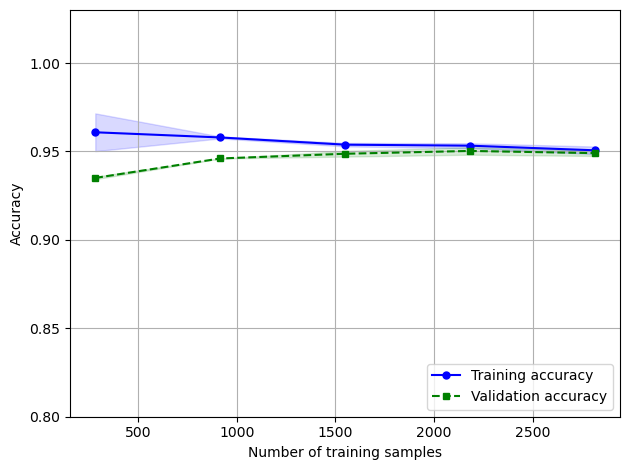

In [25]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_logistic, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

In [26]:
# Oversampling data
model_logistic.fit(x_train_over, y_train_over)

predict_result = model_logistic.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_logistic, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9332860184528035 
val : 0.9490592829250977


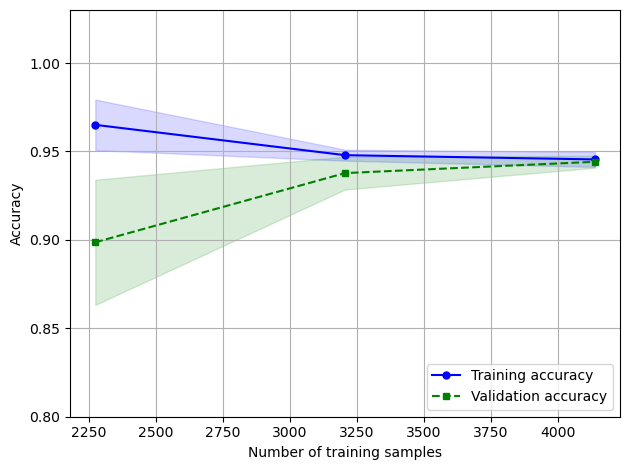

In [27]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_logistic, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

### Modeling - SVM

In [28]:
model_svm = svm.SVC(kernel='linear', C=1, probability=True)
model_svm.fit(x_train, y_train)

predict_result = model_svm.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_svm, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9368346344925479 
val : 0.9403620873269436


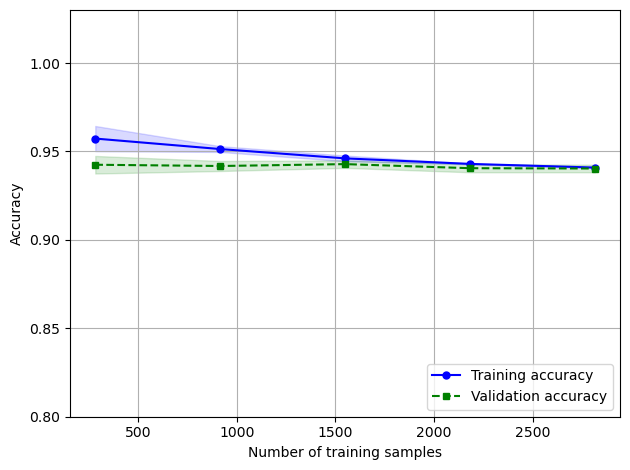

In [29]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_svm, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

In [30]:
# Oversampling data
model_svm.fit(x_train_over, y_train_over)

predict_result = model_svm.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_svm, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9318665720369056 
val : 0.9403620873269436


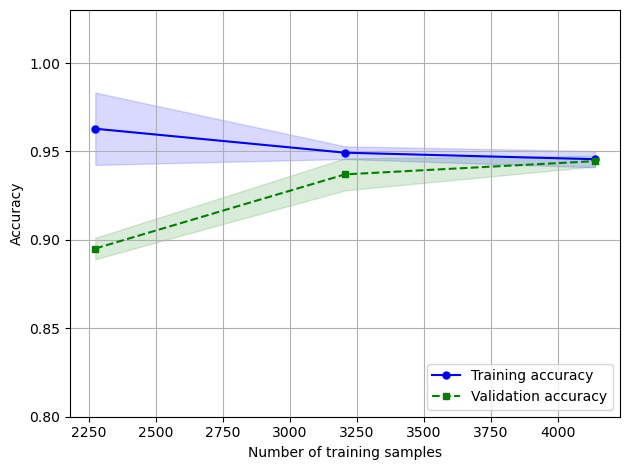

In [31]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_svm, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

In [32]:
model_svm_rbf = svm.SVC(kernel='rbf', probability=True)
model_svm_rbf.fit(x_train, y_train)

predict_result = model_svm_rbf.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_svm_rbf, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9474804826117814 
val : 0.9506567270145545


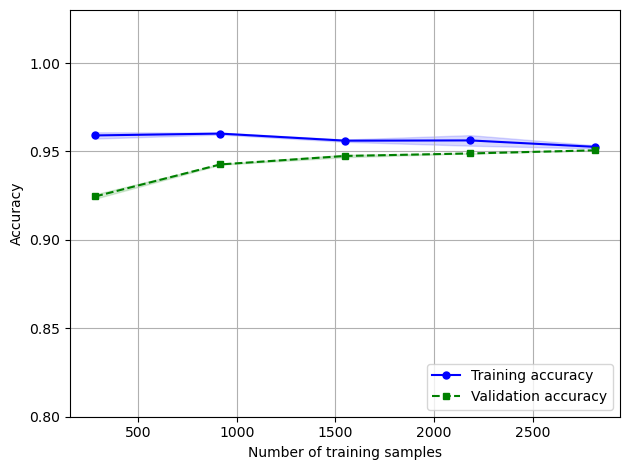

In [33]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_svm_rbf, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [34]:
# Oversampling data
model_svm_rbf.fit(x_train_over, y_train_over)

predict_result = model_svm_rbf.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_svm_rbf, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9332860184528035 
val : 0.9506567270145545


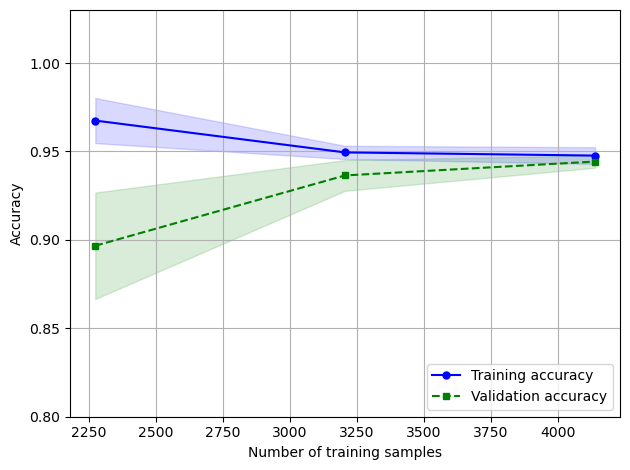

In [35]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_svm_rbf, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - Random Forest

In [36]:
model_rf = RandomForestClassifier(random_state=100)
model_rf.fit(x_train, y_train)

predict_result = model_rf.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_rf, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9439318665720369 
val : 0.9552715654952078


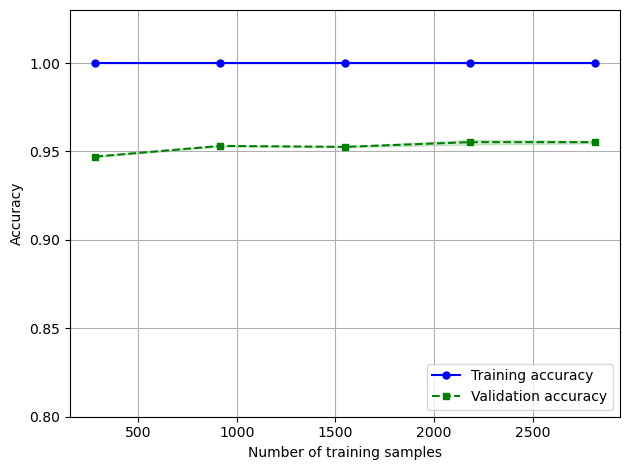

In [37]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_rf, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [38]:
# Oversampling data
model_rf.fit(x_train_over, y_train_over)

predict_result = model_rf.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_rf, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9453513129879347 
val : 0.9552715654952078


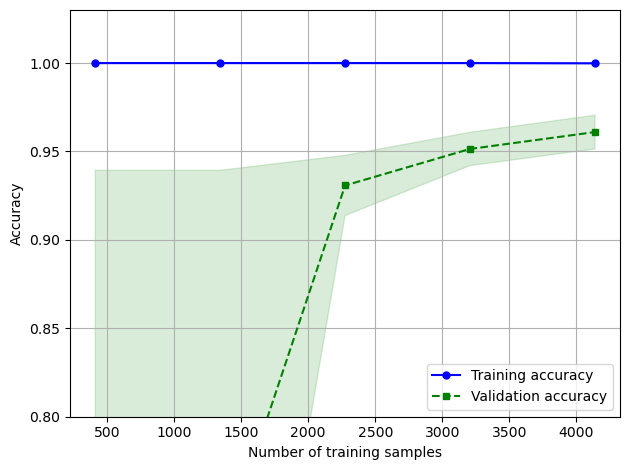

In [39]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_rf, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - DecisionTree

In [40]:
model_dt = DecisionTreeClassifier(random_state=100)
model_dt.fit(x_train, y_train)

predict_result = model_dt.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_dt, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9325762952448545 
val : 0.9341498047568335


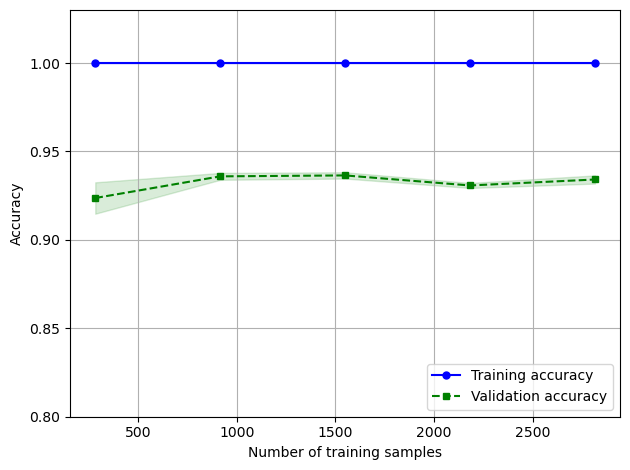

In [41]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_dt, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [42]:
# Oversampling data
model_dt.fit(x_train_over, y_train_over)

predict_result = model_dt.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_dt, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9183818310858765 
val : 0.9341498047568335


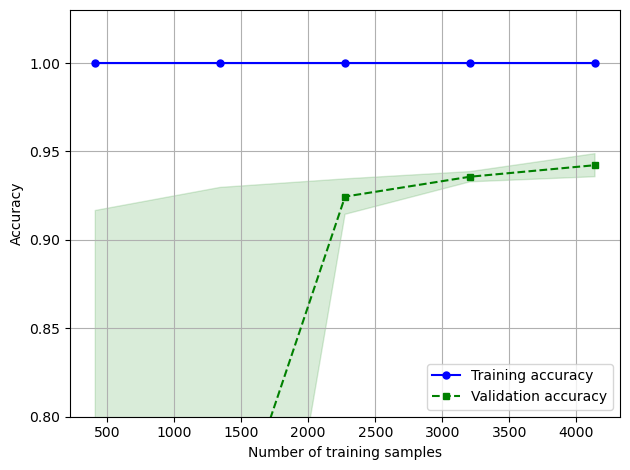

In [43]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_dt, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - KNN

In [44]:
model_kn = KNeighborsClassifier()
model_kn.fit(x_train, y_train)

predict_result = model_kn.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_kn, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9268985095812633 
val : 0.9235001774937877


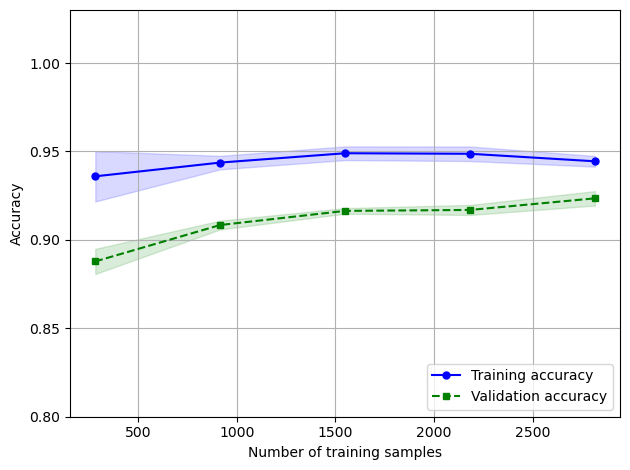

In [45]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_kn, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [46]:
# Oversampling data
model_kn.fit(x_train_over, y_train_over)

predict_result = model_kn.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_kn, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9127040454222853 
val : 0.9235001774937877


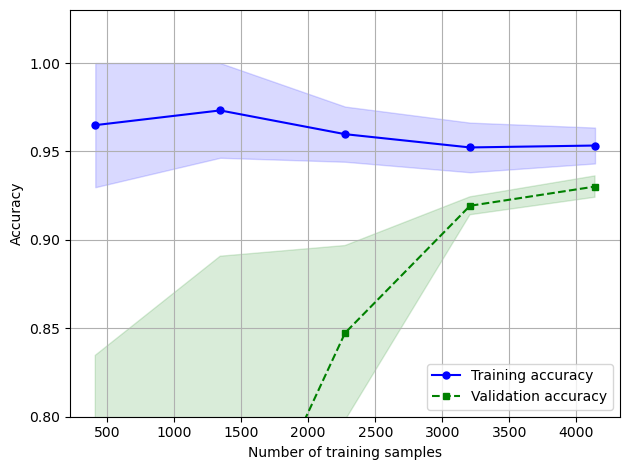

In [47]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_kn, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - Naive Bayes

In [48]:
model_nb = GaussianNB()
model_nb.fit(x_train, y_train)

predict_result = model_nb.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_nb, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.8289567068843151 
val : 0.8299609513667021


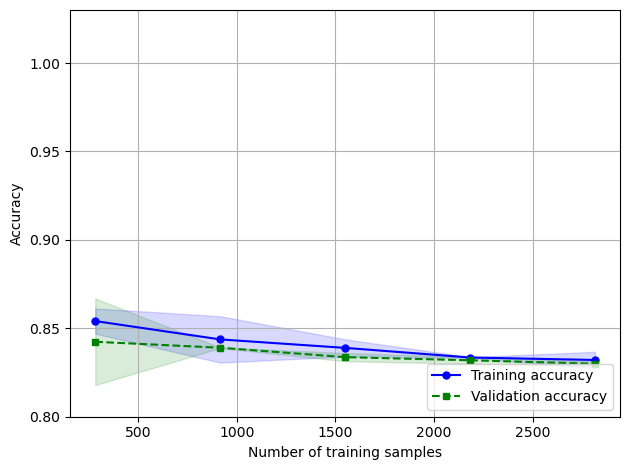

In [49]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_nb, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [50]:
# Oversampling data
model_nb.fit(x_train_over, y_train_over)

predict_result = model_nb.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_nb, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.8254080908445706 
val : 0.8299609513667021


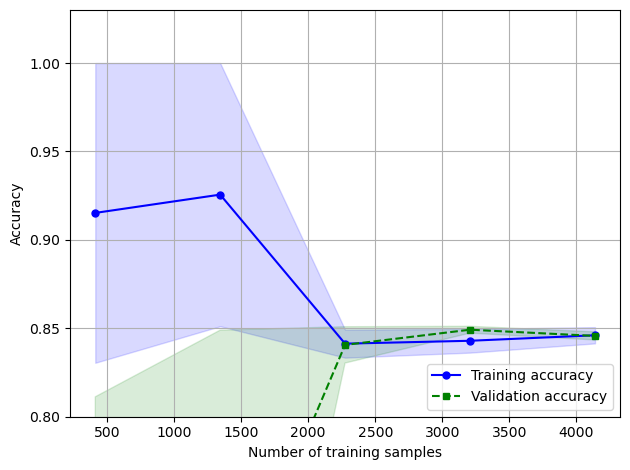

In [51]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_nb, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - GBT

In [52]:
model_gbt = GradientBoostingClassifier(random_state=100)
model_gbt.fit(x_train, y_train)

predict_result = model_gbt.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_gbt, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9474804826117814 
val : 0.9554490592829251


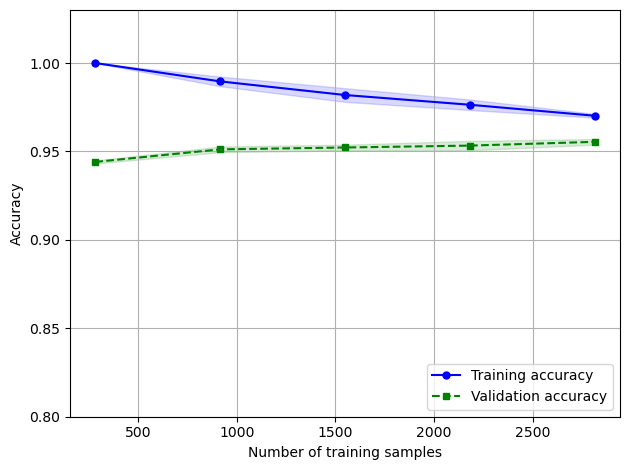

In [53]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_gbt, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [54]:
# Oversampling data
model_gbt.fit(x_train_over, y_train_over)

predict_result = model_gbt.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_gbt, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9467707594038325 
val : 0.9554490592829251


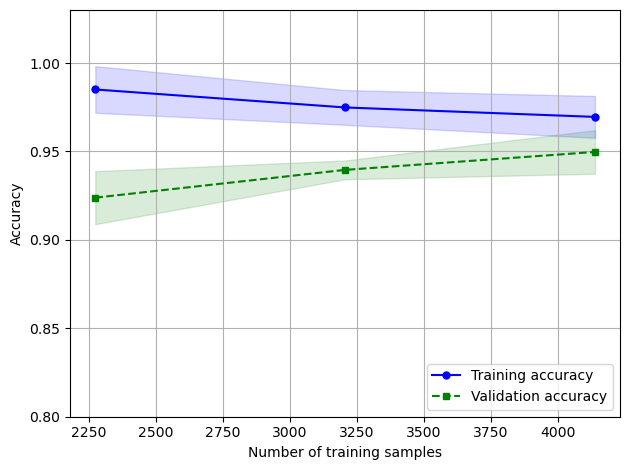

In [55]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_gbt, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - SGD

In [56]:
model_sgd = SGDClassifier(random_state=100)
model_sgd.fit(x_train, y_train)

predict_result = model_sgd.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_sgd, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9403832505322924 
val : 0.9469293574724884


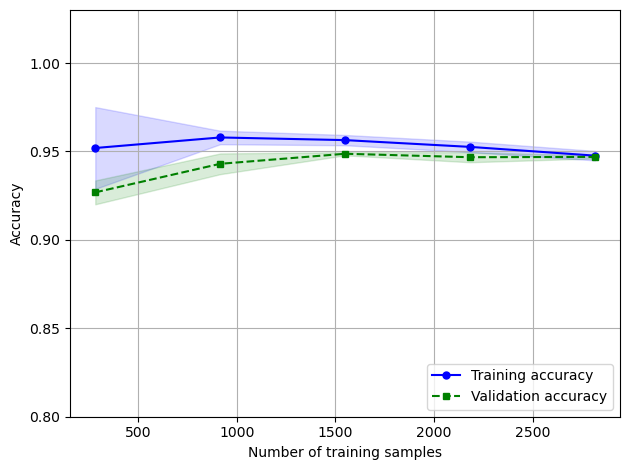

In [57]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_sgd, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [58]:
# Oversampling data
model_sgd.fit(x_train_over, y_train_over)

predict_result = model_sgd.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_sgd, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.943222143364088 
val : 0.9469293574724884


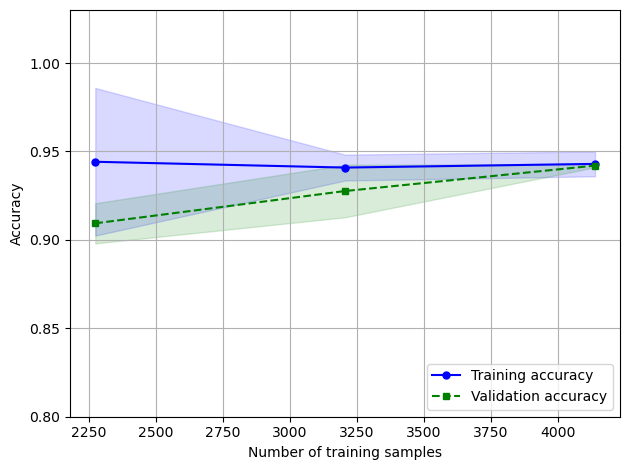

In [59]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_sgd, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - Adaboost

In [60]:
model_ada = AdaBoostClassifier(random_state=100)
model_ada.fit(x_train, y_train)

predict_result = model_ada.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_ada, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9460610361958836 
val : 0.9510117145899893


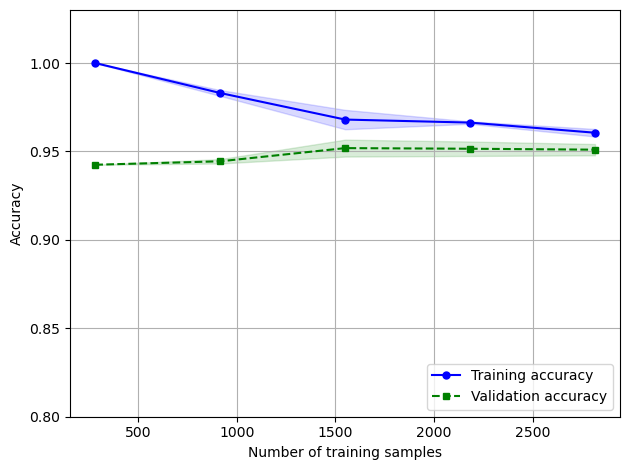

In [61]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_ada, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [62]:
# Oversampling data
model_ada.fit(x_train_over, y_train_over)

predict_result = model_ada.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_ada, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9425124201561391 
val : 0.9510117145899893


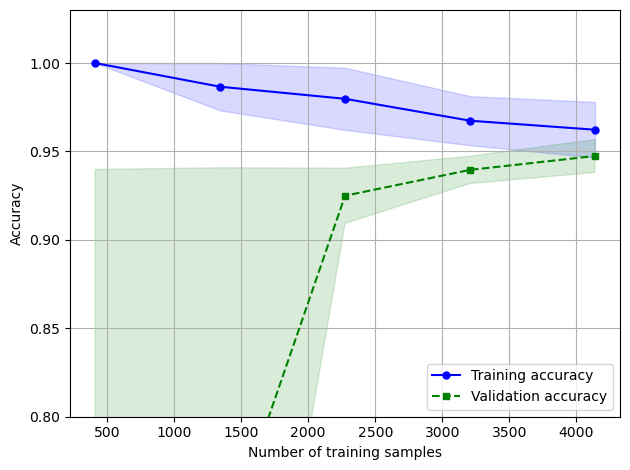

In [63]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_ada, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### One-page plot

In [64]:
def learn_vali_plot(axes, rows, cols, datas_num):
    models = [[model_logistic,model_logistic,model_svm,model_svm],
    [model_svm_rbf,model_svm_rbf,model_rf,model_rf],
    [model_dt,model_dt,model_kn,model_kn],
    [model_nb,model_nb,model_gbt,model_gbt],
    [model_sgd,model_sgd,model_ada,model_ada]]
    
    models_name = [['model_logistic','model_logistic','model_svm','model_svm'],
    ['model_svm_rbf','model_svm_rbf','model_rf','model_rf'],
    ['model_dt','model_dt','model_kn','model_kn'],
    ['model_nb','model_nb','model_gbt','model_gbt'],
    ['model_sgd','model_sgd','model_ada','model_ada']]

    datas = [[x_train, y_train], [x_train_over, y_train_over]]
    
    datas_name = [['x_train', 'y_train'], ['x_train_over', 'y_train_over']]

    train_sizes, train_scores, test_scores = learning_curve(estimator=models[rows][cols], X=datas[datas_num][0], y=datas[datas_num][1], cv=2, n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    axes[rows, cols].plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
    axes[rows, cols].fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

    axes[rows, cols].plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
    axes[rows, cols].fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

    axes[rows, cols].grid()
    axes[rows, cols].set_xlabel('Number of training samples')
    axes[rows, cols].set_ylabel('Accuracy')

    if datas_name[datas_num][0] == 'x_train':
        axes[rows, cols].set_title(models_name[rows][cols])
    else:
        axes[rows, cols].set_title(models_name[rows][cols]+'_Oversampling')

    # axes[rows, cols].legend(loc='lower right')
    # axes[rows, cols].ylim([0.8, 1.03])
    # axes[rows, cols].tight_layout()


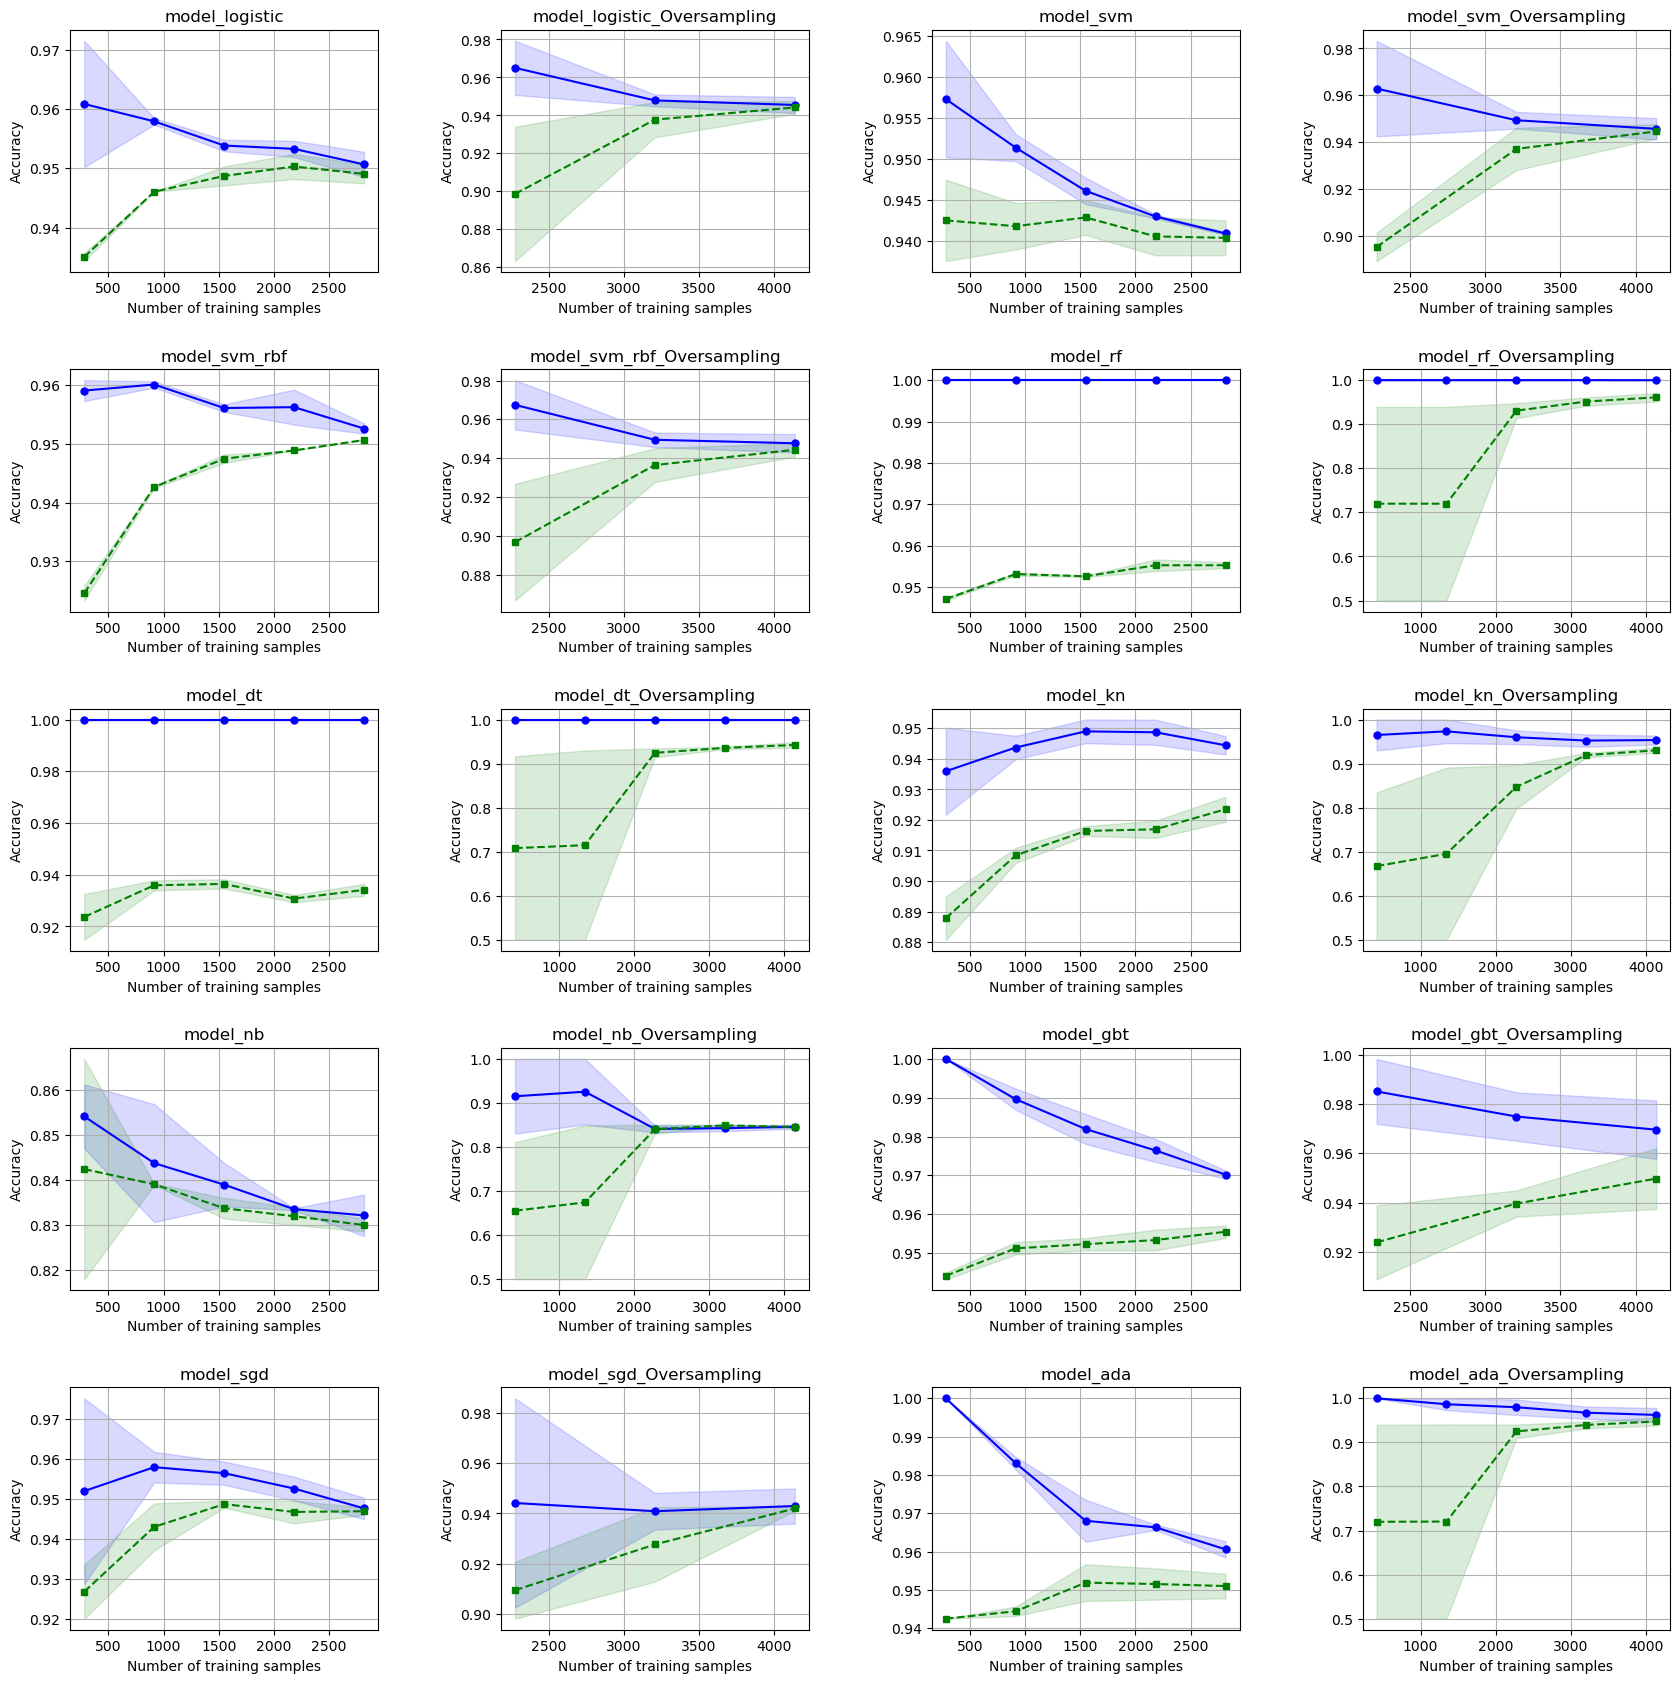

In [65]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20,20))

for i in range(5):
    for j, k in zip(range(4), [0,1,0,1]):
        # print(i, j, k)
        learn_vali_plot(ax, i, j, k)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

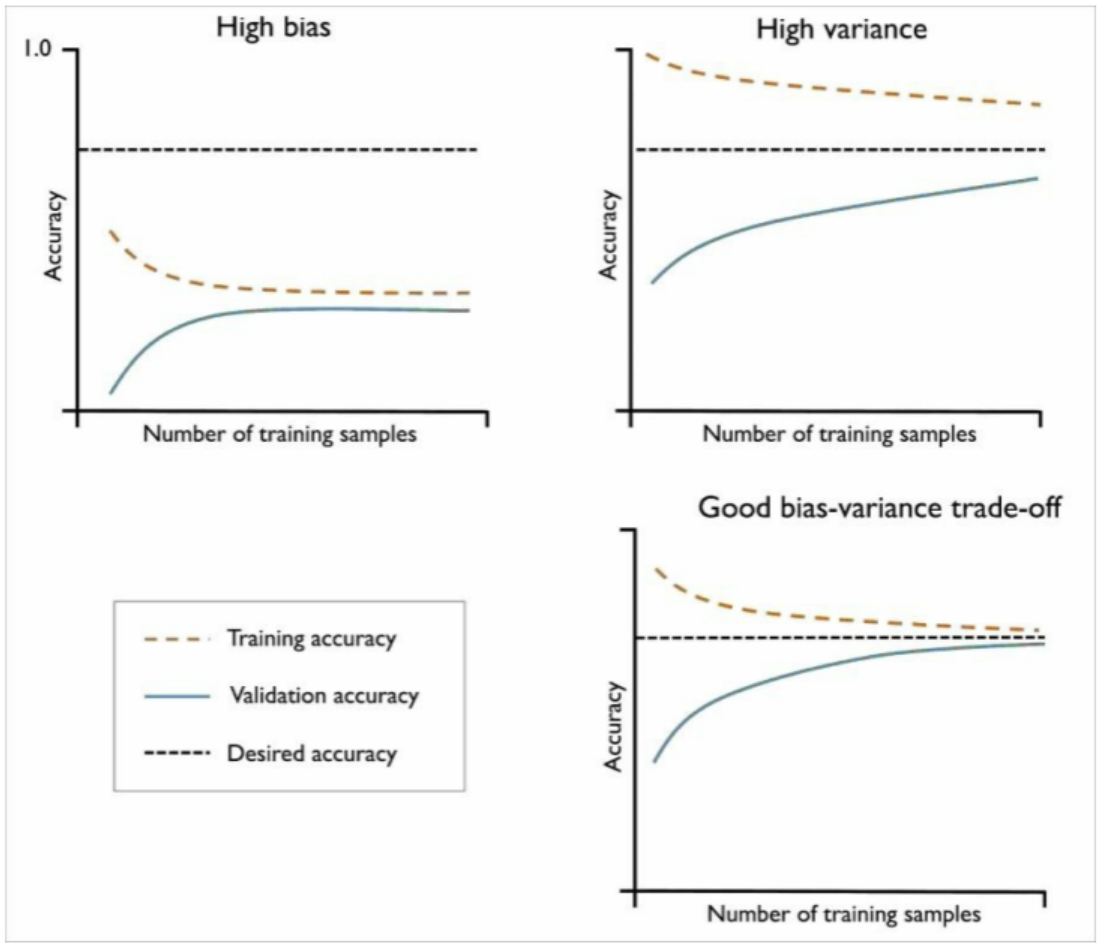